In [1]:
# Importing libraries
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# Reading the dataset
train_dir = './train/'
test_dir = './test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

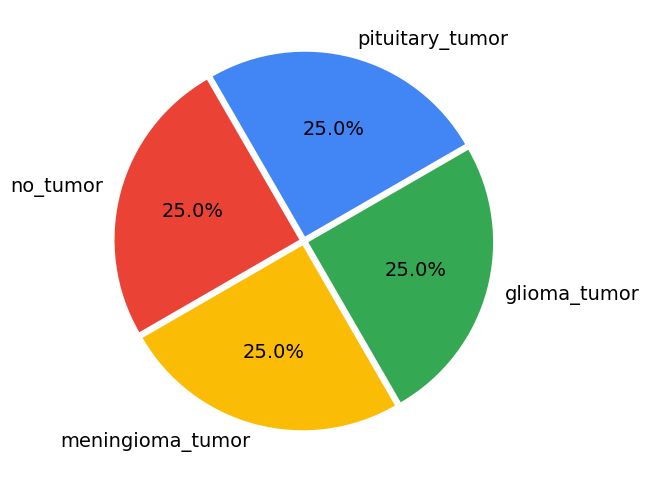

In [3]:
# Visualizing the balance of the training set
class_labels = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
class_counts = []

for class_name in class_labels:
    class_dir = os.path.join(train_dir, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)

colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})
plt.pie(class_counts, labels=class_labels, colors=colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025), startangle=30)
plt.show()

In [4]:
# Data Augmentation
IMAGE_SIZE = 128

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

In [5]:
# Opening images
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Data Generator
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [6]:
# Model (ResNet50)
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [7]:
# Train Model
batch_size = 10
steps = int(len(train_paths) / batch_size)
epochs = 50
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
646/646 [==============================] - 121s 183ms/step - loss: 1.3425 - sparse_categorical_accuracy: 0.3393
Epoch 2/50
646/646 [==============================] - 108s 167ms/step - loss: 1.2337 - sparse_categorical_accuracy: 0.4433
Epoch 3/50
646/646 [==============================] - 142s 220ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.5077
Epoch 4/50
646/646 [==============================] - 128s 197ms/step - loss: 1.1217 - sparse_categorical_accuracy: 0.5310
Epoch 5/50
646/646 [==============================] - 115s 178ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.5536
Epoch 6/50
646/646 [==============================] - 113s 175ms/step - loss: 1.0476 - sparse_categorical_accuracy: 0.5680
Epoch 7/50
646/646 [==============================] - 115s 177ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.5793
Epoch 8/50
646/646 [==============================] - 108s 167ms/step - loss: 0.9895 - sparse_categorical_accuracy: 0.5963
Epoch 9/50
646/6

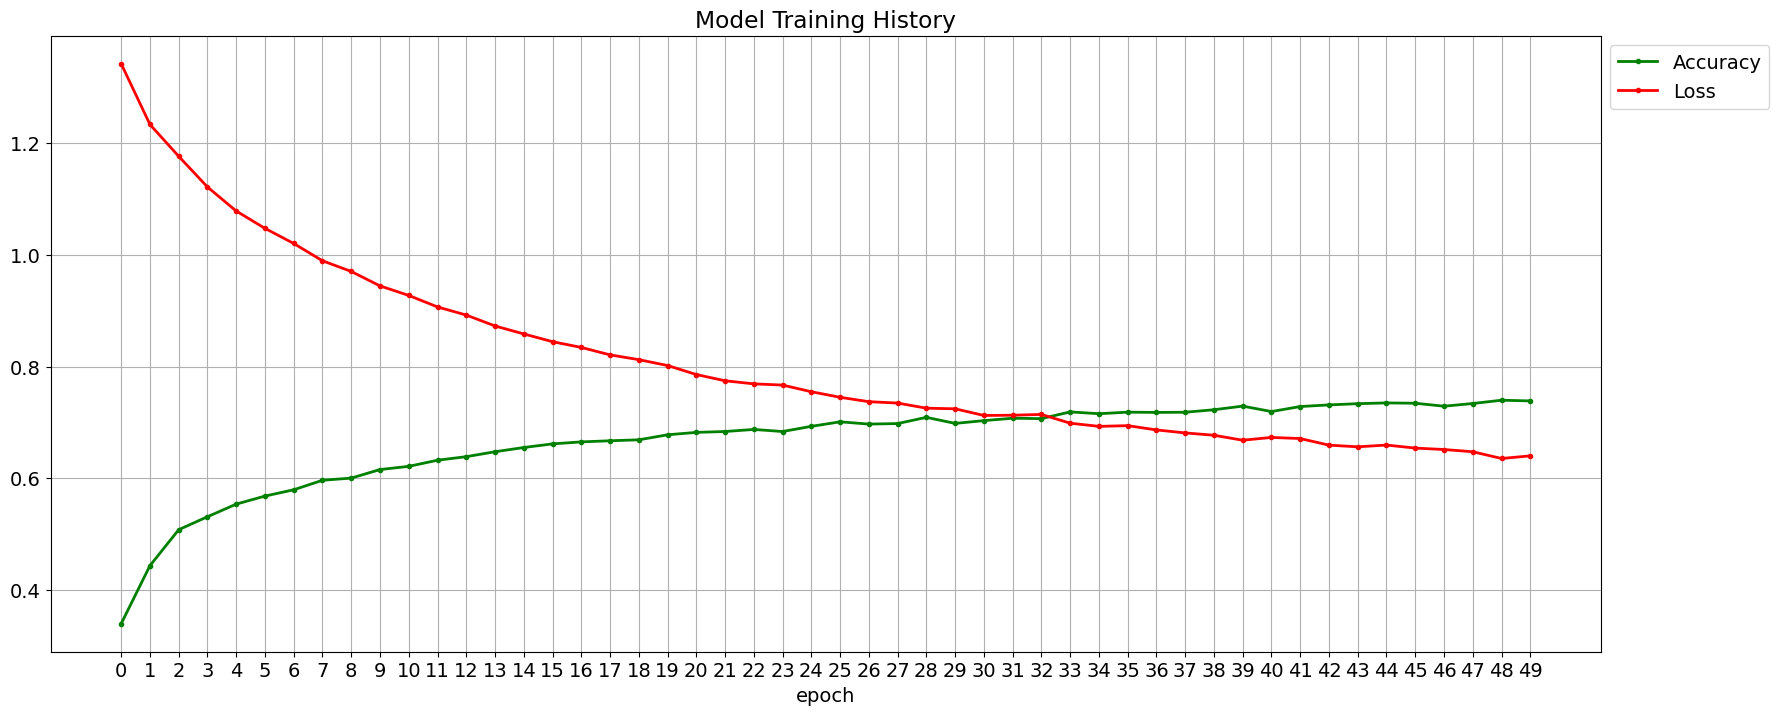

In [8]:
# Training History Plot
plt.figure(figsize=(20, 8))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
# Evaluate Model with Test Samples
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/85 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  1%|          | 1/85 [00:01<02:36,  1.87s/it]

1/1 [==============================] - 0s 499ms/step


  2%|▏         | 2/85 [00:02<01:44,  1.26s/it]

1/1 [==============================] - 0s 455ms/step


  4%|▎         | 3/85 [00:03<01:25,  1.04s/it]

1/1 [==============================] - 0s 458ms/step


  5%|▍         | 4/85 [00:04<01:13,  1.11it/s]

1/1 [==============================] - 0s 480ms/step


  6%|▌         | 5/85 [00:04<01:08,  1.18it/s]

1/1 [==============================] - 0s 466ms/step


  7%|▋         | 6/85 [00:05<01:06,  1.19it/s]

1/1 [==============================] - 0s 465ms/step


  8%|▊         | 7/85 [00:06<01:01,  1.26it/s]

1/1 [==============================] - 0s 483ms/step


  9%|▉         | 8/85 [00:07<00:59,  1.29it/s]

1/1 [==============================] - 0s 478ms/step


 11%|█         | 9/85 [00:07<00:57,  1.33it/s]

1/1 [==============================] - 0s 499ms/step


 12%|█▏        | 10/85 [00:08<00:56,  1.32it/s]

1/1 [==============================] - 0s 466ms/step


 13%|█▎        | 11/85 [00:09<00:55,  1.33it/s]

1/1 [==============================] - 0s 472ms/step


 14%|█▍        | 12/85 [00:10<00:54,  1.34it/s]

1/1 [==============================] - 0s 483ms/step


 15%|█▌        | 13/85 [00:10<00:52,  1.36it/s]

1/1 [==============================] - 0s 496ms/step


 16%|█▋        | 14/85 [00:11<00:52,  1.36it/s]

1/1 [==============================] - 0s 494ms/step


 18%|█▊        | 15/85 [00:12<00:51,  1.37it/s]

1/1 [==============================] - 0s 475ms/step


 19%|█▉        | 16/85 [00:13<00:50,  1.37it/s]

1/1 [==============================] - 0s 467ms/step


 20%|██        | 17/85 [00:13<00:48,  1.39it/s]

1/1 [==============================] - 0s 419ms/step


 21%|██        | 18/85 [00:14<00:46,  1.43it/s]

1/1 [==============================] - 0s 433ms/step


 22%|██▏       | 19/85 [00:14<00:44,  1.47it/s]

1/1 [==============================] - 0s 436ms/step


 24%|██▎       | 20/85 [00:15<00:43,  1.49it/s]

1/1 [==============================] - 0s 423ms/step


 25%|██▍       | 21/85 [00:16<00:42,  1.52it/s]

1/1 [==============================] - 0s 445ms/step


 26%|██▌       | 22/85 [00:16<00:40,  1.54it/s]

1/1 [==============================] - 0s 438ms/step


 27%|██▋       | 23/85 [00:17<00:40,  1.54it/s]

1/1 [==============================] - 0s 443ms/step


 28%|██▊       | 24/85 [00:18<00:39,  1.54it/s]

1/1 [==============================] - 0s 445ms/step


 29%|██▉       | 25/85 [00:18<00:39,  1.53it/s]

1/1 [==============================] - 0s 422ms/step


 31%|███       | 26/85 [00:19<00:38,  1.55it/s]

1/1 [==============================] - 0s 448ms/step


 32%|███▏      | 27/85 [00:20<00:37,  1.54it/s]

1/1 [==============================] - 0s 464ms/step


 33%|███▎      | 28/85 [00:20<00:38,  1.48it/s]

1/1 [==============================] - 0s 415ms/step


 34%|███▍      | 29/85 [00:21<00:37,  1.49it/s]

1/1 [==============================] - 0s 433ms/step


 35%|███▌      | 30/85 [00:22<00:36,  1.50it/s]

1/1 [==============================] - 0s 443ms/step


 36%|███▋      | 31/85 [00:22<00:35,  1.52it/s]

1/1 [==============================] - 0s 433ms/step


 38%|███▊      | 32/85 [00:23<00:34,  1.53it/s]

1/1 [==============================] - 0s 439ms/step


 39%|███▉      | 33/85 [00:24<00:33,  1.54it/s]

1/1 [==============================] - 0s 447ms/step


 40%|████      | 34/85 [00:24<00:32,  1.55it/s]

1/1 [==============================] - 0s 454ms/step


 41%|████      | 35/85 [00:25<00:32,  1.53it/s]

1/1 [==============================] - 0s 450ms/step


 42%|████▏     | 36/85 [00:26<00:32,  1.50it/s]

1/1 [==============================] - 0s 447ms/step


 44%|████▎     | 37/85 [00:26<00:31,  1.52it/s]

1/1 [==============================] - 0s 460ms/step


 45%|████▍     | 38/85 [00:27<00:31,  1.52it/s]

1/1 [==============================] - 0s 470ms/step


 46%|████▌     | 39/85 [00:28<00:31,  1.48it/s]

1/1 [==============================] - 0s 464ms/step


 47%|████▋     | 40/85 [00:28<00:30,  1.46it/s]

1/1 [==============================] - 0s 417ms/step


 48%|████▊     | 41/85 [00:29<00:29,  1.48it/s]

1/1 [==============================] - 0s 433ms/step


 49%|████▉     | 42/85 [00:30<00:28,  1.51it/s]

1/1 [==============================] - 0s 432ms/step


 51%|█████     | 43/85 [00:30<00:27,  1.52it/s]

1/1 [==============================] - 0s 421ms/step


 52%|█████▏    | 44/85 [00:31<00:26,  1.55it/s]

1/1 [==============================] - 0s 429ms/step


 53%|█████▎    | 45/85 [00:31<00:25,  1.58it/s]

1/1 [==============================] - 0s 436ms/step


 54%|█████▍    | 46/85 [00:32<00:24,  1.57it/s]

1/1 [==============================] - 0s 437ms/step


 55%|█████▌    | 47/85 [00:33<00:24,  1.57it/s]

1/1 [==============================] - 0s 439ms/step


 56%|█████▋    | 48/85 [00:33<00:23,  1.56it/s]

1/1 [==============================] - 0s 443ms/step


 58%|█████▊    | 49/85 [00:34<00:23,  1.54it/s]

1/1 [==============================] - 0s 437ms/step


 59%|█████▉    | 50/85 [00:35<00:22,  1.55it/s]

1/1 [==============================] - 0s 444ms/step


 60%|██████    | 51/85 [00:35<00:21,  1.55it/s]

1/1 [==============================] - 0s 447ms/step


 61%|██████    | 52/85 [00:36<00:21,  1.54it/s]

1/1 [==============================] - 0s 430ms/step


 62%|██████▏   | 53/85 [00:37<00:20,  1.54it/s]

1/1 [==============================] - 0s 443ms/step


 64%|██████▎   | 54/85 [00:37<00:20,  1.54it/s]

1/1 [==============================] - 0s 447ms/step


 65%|██████▍   | 55/85 [00:38<00:19,  1.55it/s]

1/1 [==============================] - 0s 439ms/step


 66%|██████▌   | 56/85 [00:39<00:18,  1.55it/s]

1/1 [==============================] - 0s 446ms/step


 67%|██████▋   | 57/85 [00:39<00:18,  1.55it/s]

1/1 [==============================] - 0s 442ms/step


 68%|██████▊   | 58/85 [00:40<00:17,  1.55it/s]

1/1 [==============================] - 0s 445ms/step


 69%|██████▉   | 59/85 [00:41<00:16,  1.57it/s]

1/1 [==============================] - 0s 446ms/step


 71%|███████   | 60/85 [00:41<00:16,  1.56it/s]

1/1 [==============================] - 0s 442ms/step


 72%|███████▏  | 61/85 [00:42<00:15,  1.54it/s]

1/1 [==============================] - 0s 459ms/step


 73%|███████▎  | 62/85 [00:43<00:15,  1.52it/s]

1/1 [==============================] - 0s 412ms/step


 74%|███████▍  | 63/85 [00:43<00:14,  1.55it/s]

1/1 [==============================] - 0s 410ms/step


 75%|███████▌  | 64/85 [00:44<00:13,  1.58it/s]

1/1 [==============================] - 0s 417ms/step


 76%|███████▋  | 65/85 [00:44<00:12,  1.60it/s]

1/1 [==============================] - 0s 462ms/step


 78%|███████▊  | 66/85 [00:45<00:12,  1.56it/s]

1/1 [==============================] - 0s 459ms/step


 79%|███████▉  | 67/85 [00:46<00:11,  1.54it/s]

1/1 [==============================] - 0s 452ms/step


 80%|████████  | 68/85 [00:46<00:11,  1.50it/s]

1/1 [==============================] - 0s 480ms/step


 81%|████████  | 69/85 [00:47<00:10,  1.47it/s]

1/1 [==============================] - 0s 432ms/step


 82%|████████▏ | 70/85 [00:48<00:10,  1.45it/s]

1/1 [==============================] - 0s 415ms/step


 84%|████████▎ | 71/85 [00:48<00:09,  1.48it/s]

1/1 [==============================] - 0s 425ms/step


 85%|████████▍ | 72/85 [00:49<00:08,  1.52it/s]

1/1 [==============================] - 0s 427ms/step


 86%|████████▌ | 73/85 [00:50<00:07,  1.54it/s]

1/1 [==============================] - 0s 445ms/step


 87%|████████▋ | 74/85 [00:50<00:07,  1.53it/s]

1/1 [==============================] - 0s 439ms/step


 88%|████████▊ | 75/85 [00:51<00:06,  1.54it/s]

1/1 [==============================] - 0s 432ms/step


 89%|████████▉ | 76/85 [00:52<00:05,  1.55it/s]

1/1 [==============================] - 0s 423ms/step


 91%|█████████ | 77/85 [00:52<00:05,  1.56it/s]

1/1 [==============================] - 0s 406ms/step


 92%|█████████▏| 78/85 [00:53<00:04,  1.58it/s]

1/1 [==============================] - 0s 427ms/step


 93%|█████████▎| 79/85 [00:54<00:03,  1.58it/s]

1/1 [==============================] - 0s 443ms/step


 94%|█████████▍| 80/85 [00:54<00:03,  1.57it/s]

1/1 [==============================] - 0s 437ms/step


 95%|█████████▌| 81/85 [00:55<00:02,  1.57it/s]

1/1 [==============================] - 0s 436ms/step


 96%|█████████▋| 82/85 [00:55<00:01,  1.57it/s]

1/1 [==============================] - 0s 443ms/step


 98%|█████████▊| 83/85 [00:56<00:01,  1.56it/s]

1/1 [==============================] - 0s 441ms/step


 99%|█████████▉| 84/85 [00:57<00:00,  1.56it/s]

1/1 [==============================] - 0s 438ms/step


100%|██████████| 85/85 [00:57<00:00,  1.56it/s]

1/1 [==============================] - 1s 1s/step


86it [00:59,  1.46it/s]                        
86it [00:59,  1.46it/s]


In [10]:
# Display classification report
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.57      0.45      0.50       686
meningioma_tumor       0.65      0.43      0.52       684
        no_tumor       0.72      0.87      0.79       683
 pituitary_tumor       0.60      0.81      0.69       692

        accuracy                           0.64      2745
       macro avg       0.64      0.64      0.62      2745
    weighted avg       0.64      0.64      0.62      2745



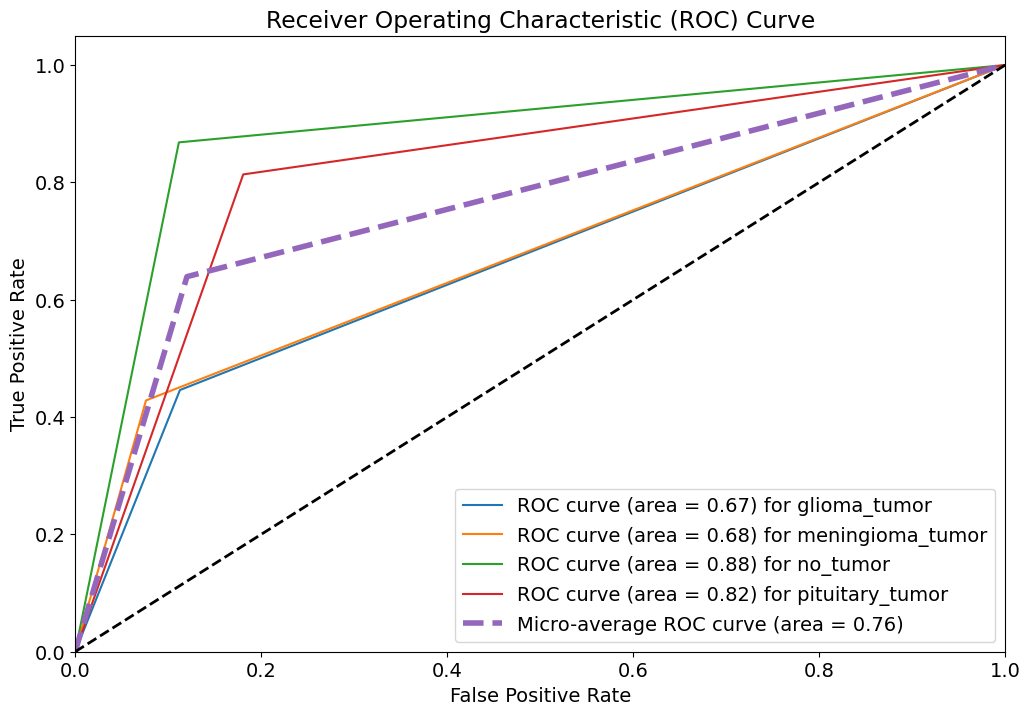

In [11]:
# Converte as labels para one-hot encoding
y_true_one_hot = label_binarize(y_true, classes=unique_labels)
y_pred_one_hot = label_binarize(y_pred, classes=unique_labels)

# Calcula a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(unique_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula a média da curva ROC para todas as classes
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_one_hot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plota a curva ROC para cada classe
plt.figure(figsize=(12, 8))
for i in range(len(unique_labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {unique_labels[i]}')

# Plota a curva ROC média
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle='--', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

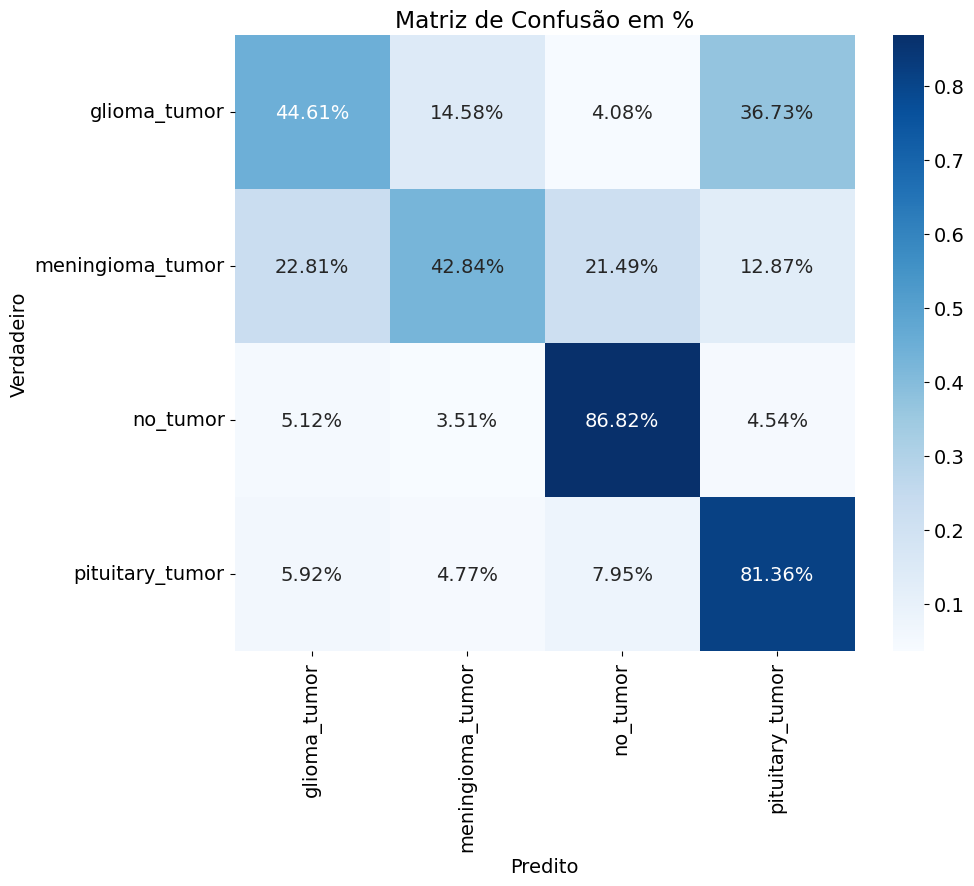

In [12]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Calcula a matriz de confusão em termos percentuais
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plota a matriz de confusão em termos percentuais usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matriz de Confusão em %')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()